# Function defs EXPERT

Esta tabla contiene la información de las definiciones de funciones EXPERT.  --> ABEL COMPLETAR <--

## 1 - Obtencion de datos

In [2]:
import matplotlib.pyplot as plt
from notebooks_utils import *

TARGET_FEATURE = 'functiondef__expertise_level'
TARGET_CLASS = 'EXPERT'
full_table = get_data('functiondefs')

instances_for_class_low = len(full_table[full_table[TARGET_FEATURE] == "BEGINNER"])
instances_for_class_high = len(full_table[full_table[TARGET_FEATURE] == "EXPERT"])

print(f"The dataset contains {instances_for_class_low} ({instances_for_class_low/len(full_table)*100:.4}%) instances for BEGINNER class and {instances_for_class_high} ({instances_for_class_high/len(full_table)*100:.4}%) for EXPERT class.")

2024-05-13 10:13:36.007551 Data cache files found ...
2024-05-13 10:13:36.085704 Data cache files successfully loaded!!
The dataset contains 59873 (40.56%) instances for BEGINNER class and 87754 (59.44%) for EXPERT class.


In [21]:
full_table = full_table[full_table[TARGET_FEATURE] == TARGET_CLASS]

# Table name, features and target.
TABLE_NAME = 'functiondefs'
TABLE_FEATURES = ['functiondef__name_convention', 'functiondef__number_of_characters', 'functiondef__is_magic', 'functiondef__is_private', 'functiondef__body_count', 'functiondef__expressions_pct', 'functiondef__is_async', 'functiondef__number_of_decorators', 'functiondef__has_return_type_annotation', 'functiondef__has_doc_string', 'functiondef__height', 'functiondef__type_annotations_pct']

# Load features and target.
X = full_table[TABLE_FEATURES]

# Print information about the loaded table.
print(f'Features shape: {X.shape}')

print(f'As we can see the downloaded data contains a total of {X.shape[0]} instances. Each of the instances corresponds to a program. For each program we have {X.shape[1]} attributes.')

2024-05-12 19:39:00.644490 Data cache files found ...
2024-05-12 19:39:00.686490 Data cache files successfully loaded!!
Features shape: (147627, 13)
Target shape: (147627,)
As we can see the downloaded data contains a total of 147627 instances. Each of the instances corresponds to a program. For each program we have 13 attributes.


## 2 - Exploracion de datos

Una vez tenemos nuestra tabla en un dataframe el siguiente paso es explorarla para ver qué tipo de información contiene.

In [2]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147627 entries, 0 to 147626
Data columns (total 12 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   functiondef__name_convention             147627 non-null  object 
 1   functiondef__number_of_characters        147627 non-null  int64  
 2   functiondef__is_private                  147627 non-null  bool   
 3   functiondef__body_count                  147627 non-null  int64  
 4   functiondef__expressions_pct             147627 non-null  float64
 5   functiondef__is_async                    147627 non-null  bool   
 6   functiondef__number_of_decorators        147627 non-null  int64  
 7   functiondef__has_return_type_annotation  147627 non-null  bool   
 8   functiondef__has_doc_string              147627 non-null  bool   
 9   functiondef__height                      147627 non-null  int64  
 10  functiondef__type_annotations_pc

Cómo podemos ver la tabla está compuesta por 6 variables numéricas, 5 variables boleanas y dos de tipo objeto. Las dos últimas variables son la etiqueta de la instancia y el name convention. Sin embargo, en algunas ocasiones estas últimas clases no las vamos a utilizar. Por ejemplo, si queremos obtener clusters por medio de aprendizaje no supervisado.

### 2.1 - Duplicados
Miramos si la tabla tiene entradas duplicadas.

In [23]:
number_of_duplicated_entries = sum(full_table.duplicated(subset=TABLE_FEATURES))
duplicated_entries_pct = number_of_duplicated_entries / len(full_table) * 100
print(f"The dataset contains [{duplicated_entries_pct:.4}%] of duplicated entries.")

The dataset contains [76.75%] of duplicated entries.


### 2.3 - Valores Nulos 
Miramos si alguna de las variables que contiene la tabla contiene algún valor que sea nulo.

In [24]:
X.isnull().sum()

functiondef__name_convention               0
functiondef__number_of_characters          0
functiondef__is_magic                      0
functiondef__is_private                    0
functiondef__body_count                    0
functiondef__expressions_pct               0
functiondef__is_async                      0
functiondef__number_of_decorators          0
functiondef__has_return_type_annotation    0
functiondef__has_doc_string                0
functiondef__height                        0
functiondef__type_annotations_pct          0
functiondef__expertise_level               0
dtype: int64

In [25]:
print_empty_cols(X)

functiondef__name_convention
----------------------------
0 instancias no tienen un valor para la columna functiondef__name_convention


functiondef__number_of_characters
---------------------------------
0 instancias no tienen un valor para la columna functiondef__number_of_characters


functiondef__is_magic
---------------------
0 instancias no tienen un valor para la columna functiondef__is_magic


functiondef__is_private
-----------------------
0 instancias no tienen un valor para la columna functiondef__is_private


functiondef__body_count
-----------------------
0 instancias no tienen un valor para la columna functiondef__body_count


functiondef__expressions_pct
----------------------------
0 instancias no tienen un valor para la columna functiondef__expressions_pct


functiondef__is_async
---------------------
0 instancias no tienen un valor para la columna functiondef__is_async


functiondef__number_of_decorators
---------------------------------
0 instancias no tienen un valo

### 2.4 - Describimos los valores de las variables de la tabla.

In [26]:
np.transpose(X.describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
functiondef__name_convention,147627,7,SnakeCase,106664,NaN,NaN,NaN,NaN,NaN,NaN,NaN
functiondef__number_of_characters,147627.0,NaN,NaN,NaN,13.701328,8.257348,1.0,8.0,12.0,18.0,87.0
functiondef__is_magic,147627,2,False,127669,NaN,NaN,NaN,NaN,NaN,NaN,NaN
functiondef__is_private,147627,2,False,126933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
functiondef__body_count,147627.0,NaN,NaN,NaN,4.094156,4.79151,1.0,1.0,3.0,5.0,364.0
functiondef__expressions_pct,147627.0,NaN,NaN,NaN,0.221231,0.276248,0.0,0.0,0.125,0.333333,1.0
functiondef__is_async,147627,2,False,144020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
functiondef__number_of_decorators,147627.0,NaN,NaN,NaN,0.191144,0.493714,0.0,0.0,0.0,0.0,46.0
functiondef__has_return_type_annotation,147627,2,False,106554,NaN,NaN,NaN,NaN,NaN,NaN,NaN
functiondef__has_doc_string,147627,1,False,147627,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vamos a discretizar las variables numericas, agrupando conjuntos de valores en categorias, para hacer un análisis de los datos. Para cada variable es necesario ver la distribucion de lo valores para hacer los bins (categorias).

In [27]:
# DISCRETIZATION
X_copy = X.copy()

discretized_columns = {
    "functiondef__expressions_pct": [(0.0, 0.0), (0.0, 0.125), (0.125, 0.33), (0.33, inf)], # min: 0 ; max: 1
    "functiondef__number_of_decorators": [(0.0, 0.0), (0.0, inf)], # min: 0 ; max: 46
    "functiondef__type_annotations_pct": [(0.0, 0.0), (0.0, 0.5), (0.5, inf)], # min: 0 ; max: 1
    "functiondef__number_of_characters": [(1.0, 8.0), (8.0, 12), (12, 18), (18, inf)], # min: 1 ; max: 87
    "functiondef__body_count": [(1.0, 1.0), (1.0, 3.0), (3.0, 5.0), (5.0, inf)], # min: 1 ; max: 364
    "functiondef__height": [(1.0, 1.0), (1.0, 1.9), (2.0, 2.0), (2.0, inf)], # min: 1 ; max: 10
}

discretize_columns(X_copy, discretized_columns)
    
# SINGLE FEATURE
print("--- SINGLE FEATURE ---")
print(get_statistics(X_copy, ['functiondef__expressions_pct'], 10))
print(get_statistics(X_copy, ['functiondef__number_of_decorators'], 10))
print(get_statistics(X_copy, ['functiondef__type_annotations_pct'], 10))
print(get_statistics(X_copy, ['functiondef__number_of_characters'], 10))
print(get_statistics(X_copy, ['functiondef__body_count'], 10))
print(get_statistics(X_copy, ['functiondef__height'], 10))
#print(get_statistics(X_copy, ['functiondef__name_convention'], 10))
print(get_statistics(X_copy, ['functiondef__is_private'], 10))
print(get_statistics(X_copy, ['functiondef__is_magic'], 10))
print(get_statistics(X_copy, ['functiondef__is_async'], 10))
print(get_statistics(X_copy, ['functiondef__has_return_type_annotation'], 10))
print(get_statistics(X_copy, ['functiondef__has_doc_string'], 10))

# 2 FEATURES
print("--- TWO FEATURES ---")
print(get_statistics(X_copy, ['functiondef__number_of_characters', 'functiondef__name_convention_SnakeCase'], 10))
print(get_statistics(X_copy, ['functiondef__number_of_characters', 'functiondef__name_convention_Lower'], 10))

# 3 FEATURES
print("--- THREE FEATURES ---")
#print(get_statistics(X_copy, ['module__class_defs_pct', 'module__function_defs_pct', 'module__enum_defs_pct'], 10))

--- SINGLE FEATURE ---
functiondef__expressions_pct  count  percentage
                   [0.0_0.0]  68424   46.349245
                  [0.33_inf]  48278   32.702690
                [0.125_0.33)  26164   17.723045
                 [0.0_0.125)   4761    3.225020

functiondef__number_of_decorators  count  percentage
                        [0.0_0.0] 122326   82.861536
                        [0.0_inf]  25301   17.138464

functiondef__type_annotations_pct  count  percentage
                        [0.0_0.0]  99781   67.589940
                        [0.5_inf]  44883   30.402975
                        [0.0_0.5)   2963    2.007085

functiondef__number_of_characters  count  percentage
                         [8.0_12)  42798   28.990632
                          [12_18)  38037   25.765612
                         [18_inf]  37598   25.468241
                        [1.0_8.0)  29194   19.775515

functiondef__body_count  count  percentage
              [5.0_inf]  42641   28.884283
           

KeyError: 'functiondef__name_convention_SnakeCase'

Hay que corregir el doc_string. SnakeCase tiende a tener nombres muy largos. Lower tiende a tener nombres muy cortos.

In [28]:
def normalize_datatypes(X:pd.DataFrame) -> (pd.DataFrame, [str]):
    X = pd.get_dummies(X)
    X = X.astype('float32')        
    columns_names = X.columns.tolist()
    return X, columns_names

X, TABLE_FEATURES = normalize_datatypes(X)
# Print information about the loaded table
print(f'Features shape: {X.shape}')

Features shape: (147627, 20)
Target shape: (147627,)


#### Muestra la matriz de correlación de pearson entre las variables de la tabla.

<Axes: >

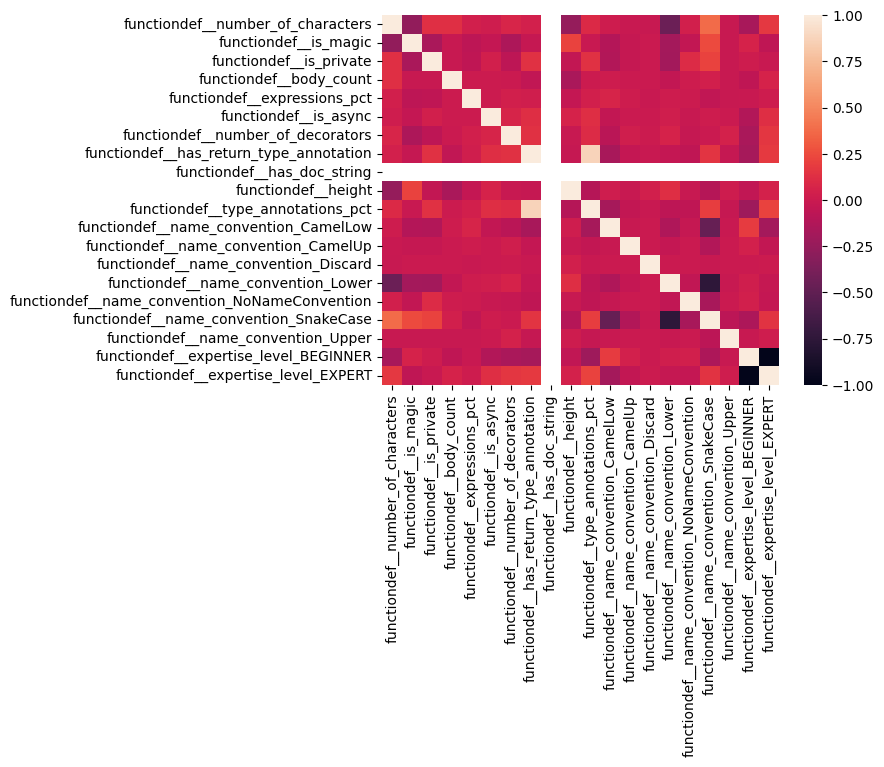

In [29]:
sns.heatmap(X.corr(), annot=False)

La relación entre private y magic methods pct es debido a que hasta ahora siempre que un metodo era magic se marcaba como privado tambien

## 3 - Detección de valores atípicos (outliers)
Una vez sabemos qué datos contiene la tabla, analizaremos los valores que toma cada una de las variables de cada instancia. El objetivo es identificar posibles valores atípicos que nos dificulten la realización de futuras tareas. 
Tras su análisis, se puede concluir que un valor:
    - **Es erróneo**. En este caso hay que tomar una decisión para cada caso, siendo los tratamientos más extendidos son listwise, pairwise, drop variables, mean/median imputation, most frequent, separate category, zero imputation, cold deck, hot deck,(stochastic) regression, k-NN and multiple imputation. Los resultados de imputación regresiva, k-NN y múltiple dan buenos resultados, aunque, como se ha indicado, es necesario el estudio en cada caso.
    - **Es correcto, pero anómalo**. Se documenta su existencia para su posible discusión y se mantiene en el dataset. En estos casos se hace necesaria la utilización de algoritmos y estadísticos que no sean muy sensibles a dichos valores anómalos.

## Univariate
Para cada uno de los atributos se debe realizar un análisis y detección de valores atípicos, estudiando su posible causa. 
Existen diversas formas de calcular los valores anómalos. 

### Variables numéricas
Para las variables numéricas, se suele identificar: 
    - a) Valor atípico leve es el que está fuera de $[Q1 - 1.5IQR, Q3 + 1.5IQR]$, donde $IQR = Q3-Q1$.
    - b) Valor atípico extremo está fuera de $[Q1 - 3IQR, Q3 + 3IQR]$.

La idea es probar con a) y si hay pocas instancias analizarlas. Si hubiese muchas, mirar b) y analizar si fuesen pocas. No hay un algoritmo o método estipulado, puesto que depende del dominio del problema y de los datos.

Los límites de Tukey se basan en los cuartiles de los datos y son sensibles a la presencia de sesgo en la distribución. Cuando hay asimetría en los datos, los límites de Tukey pueden no ser tan efectivos para identificar outliers de manera equitativa en ambos extremos de la distribución. El Coeficiente de Medcouple es útil para identificar la asimetría en los datos, especialmente en presencia de valores atípicos o sesgados. Es una medida robusta porque no se ve tan afectada por valores extremos como la media y la desviación estándar. El MC puede proporcionar información adicional sobre la asimetría de la distribución, lo que te permite ajustar los límites de Tukey de manera más apropiada para tu conjunto de datos específico. Una posible variacion de los límites de Tukey teniendo en cuenta MC podria ser: 
   - Si MC es mayor que 0 (asimetría hacia la derecha):
      - low = (q1-1.5 * math.exp(-4*mc) * iqr)
      - high = (q3+1.5 * math.exp(3.5*mc) * iqr)
   - Si la asimetriza es hacia la izquierda:    
      - low = (q1-1.5 * math.exp(-3.5*mc) * iqr)
      - high = (q3+1.5 * math.exp(4*mc) * iqr)


### Variables categóricas
Para las variables categóricas no existe el concepto de valor anómalo, pero sí se puede considerar en base a un análisis de frecuencia. Por ejemplo, que el uso de una categoría sea residual, pudiendo tener un 0.1% de instancias en el dataset. Para detectar estos valores, se puede fijar un valor mínimo de frecuencia en función del número posible de valores de la variable categórica (2 en el caso de una variable booleana). Por ejemplo, un umbral de $\frac{0.2\%}{valores}$ (0.1% en el caso de una variable booleana)

## Analisis detallado de variables
Para cada una de las 10 variable (3 booleanas, 4 porcentuales y 3 numericas) se hara un analisis detallado 

### Variable is_private (1/11)
Esta variable es de tipo booleano y representa si la función es privada.

<Axes: xlabel='functiondef__is_private', ylabel='Count'>

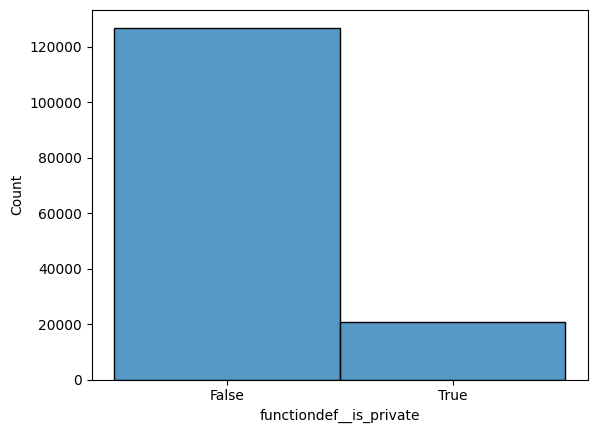

In [14]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['functiondef__is_private'], discrete=True)

In [15]:
num_true_values = len(X[X['functiondef__is_private'] == True])
num_false_values = len(X[X['functiondef__is_private'] == False])
std = X['functiondef__is_private'].std()
freq_true = len(X[X['functiondef__is_private'] == True]) / len(X['functiondef__is_private'])
freq_false = len(X[X['functiondef__is_private'] == False]) / len(X['functiondef__is_private'])
print(f'La variable is_private contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable is_private a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable is_private a False es {freq_false}.')

La variable is_private contiene 20694 valores verdaderos y 126933 valores falsos. Y, la desviación típica es de 0.3471723794937134
La frecuencia con la que programa puede tener la variable is_private a True es 0.1401776097868276.
La frecuencia con la que programa puede tener la variable is_private a False es 0.8598223902131724.


In [16]:
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'functiondef__is_private', possible_values)

La variable functiondef__is_private contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable functiondef__is_private toma el valor de 0.0 en un 85.98% de los items.
La variable functiondef__is_private toma el valor de 1.0 en un 14.02% de los items.


In [17]:
X[X['functiondef__is_private'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])


,functiondef__number_of_characters,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper,functiondef__expertise_level_BEGINNER,functiondef__expertise_level_EXPERT
count,20694.000000,20694.0,20694.000000,20694.000000,20694.000000,20694.000000,20694.000000,20694.0,20694.000000,20694.000000,20694.0,20694.0,20694.0,20694.0,20694.000000,20694.000000,20694.000000,20694.000000,20694.000000
mean,16.347155,1.0,3.836861,0.180520,0.037016,0.112206,0.426404,0.0,1.708080,0.353729,0.0,0.0,0.0,0.0,0.036097,0.963661,0.000242,0.421185,0.578815
std,7.022659,0.0,3.826918,0.235946,0.188804,0.327205,0.494566,0.0,0.571793,0.402733,0.0,0.0,0.0,0.0,0.186537,0.187137,0.015542,0.493761,0.493761
min,2.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,1.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000
50%,15.000000,1.0,3.000000,0.071429,0.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000
75%,20.000000,1.0,5.000000,0.333333,0.000000,0.000000,1.000000,0.0,2.000000,0.666667,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,1.000000
max,54.000000,1.0,172.000000,1.000000,1.000000,3.000000,1.000000,0.0,7.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


### Variable is_magic (2/11)
Esta variable es de tipo booleano y representa si la función es de la forma __\w__.

<Axes: xlabel='functiondef__is_magic', ylabel='Count'>

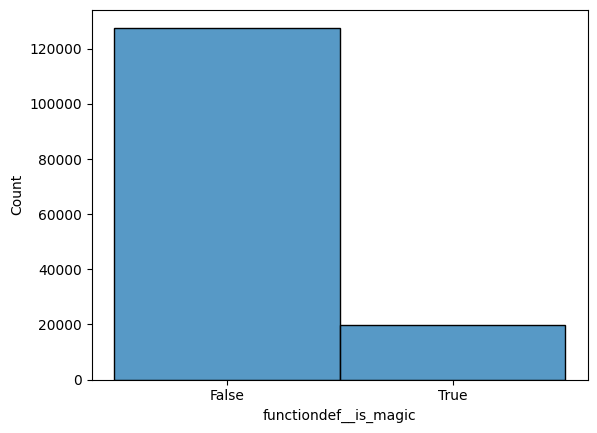

In [30]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['functiondef__is_magic'], discrete=True)

In [31]:
#ANALISIS DE DISTRIBUCIÓN DE DATOS
num_true_values = len(X[X['functiondef__is_magic'] == True])
num_false_values = len(X[X['functiondef__is_magic'] == False])
std = X['functiondef__is_magic'].std()
freq_true = len(X[X['functiondef__is_magic'] == True]) / len(X['functiondef__is_magic'])
freq_false = len(X[X['functiondef__is_magic'] == False]) / len(X['functiondef__is_magic'])
print(f'La variable is_magic contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable is_magic a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable is_magic a False es {freq_false}.')

La variable is_magic contiene 19958 valores verdaderos y 127669 valores falsos. Y, la desviación típica es de 0.34192976355552673
La frecuencia con la que programa puede tener la variable is_magic a True es 0.1351920719109648.
La frecuencia con la que programa puede tener la variable is_magic a False es 0.8648079280890352.


In [32]:
#PROBABILIDAD DE VALORES
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'functiondef__is_magic', possible_values)

La variable functiondef__is_magic contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable functiondef__is_magic toma el valor de 0.0 en un 86.48% de los items.
La variable functiondef__is_magic toma el valor de 1.0 en un 13.52% de los items.


In [33]:
#VALORES DE LOS DATOS CONDICIONADOS A TRUE/FALSE
X[X['functiondef__is_magic'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper,functiondef__expertise_level_BEGINNER,functiondef__expertise_level_EXPERT
count,19958.000000,19958.0,19958.0,19958.000000,19958.000000,19958.000000,19958.000000,19958.000000,19958.0,19958.000000,19958.000000,19958.0,19958.0,19958.0,19958.0,19958.0,19958.0,19958.0,19958.000000,19958.000000
mean,8.079367,1.0,0.0,3.901744,0.176632,0.011224,0.014581,0.245566,0.0,2.115342,0.225278,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.478755,0.521245
std,1.201256,0.0,0.0,5.053843,0.264231,0.105348,0.122352,0.430433,0.0,0.403577,0.327152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.499561,0.499561
min,6.000000,1.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000
25%,8.000000,1.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000
50%,8.000000,1.0,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,1.000000
75%,8.000000,1.0,0.0,5.000000,0.285714,0.000000,0.000000,0.000000,0.0,2.000000,0.500000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,1.000000
max,28.000000,1.0,0.0,172.000000,1.000000,1.000000,2.000000,1.000000,0.0,5.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,1.000000


### Variable is_async (3/11)
Esta variable es booleana y representa si la función es asincrona.

<Axes: xlabel='functiondef__is_async', ylabel='Count'>

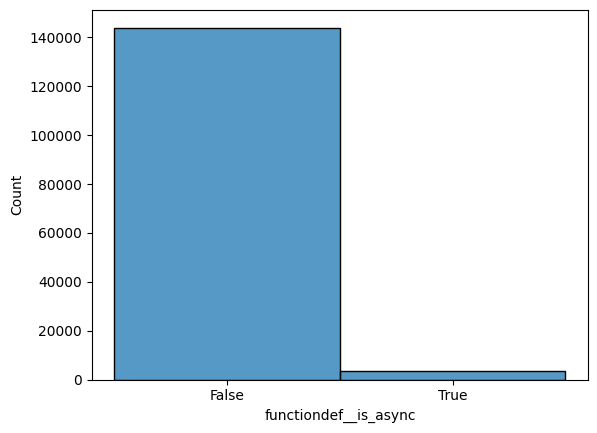

In [34]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['functiondef__is_async'], discrete=True)

In [35]:
#ANALISIS DE DISTRIBUCIÓN DE DATOS
num_true_values = len(X[X['functiondef__is_async'] == True])
num_false_values = len(X[X['functiondef__is_async'] == False])
std = X['functiondef__is_async'].std()
freq_true = len(X[X['functiondef__is_async'] == True]) / len(X['functiondef__is_async'])
freq_false = len(X[X['functiondef__is_async'] == False]) / len(X['functiondef__is_async'])
print(f'La variable is_async contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable is_async a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable is_async a False es {freq_false}.')

La variable is_async contiene 3607 valores verdaderos y 144020 valores falsos. Y, la desviación típica es de 0.154390349984169
La frecuencia con la que programa puede tener la variable is_async a True es 0.02443319988890921.
La frecuencia con la que programa puede tener la variable is_async a False es 0.9755668001110908.


In [36]:
#PROBABILIDAD DE VALORES
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'functiondef__is_async', possible_values)

La variable functiondef__is_async contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable functiondef__is_async toma el valor de 0.0 en un 97.56% de los items.
La variable functiondef__is_async toma el valor de 1.0 en un 2.443% de los items.


In [37]:
#VALORES DE LOS DATOS CONDICIONADOS A TRUE/FALSE
X[X['functiondef__is_async'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper,functiondef__expertise_level_BEGINNER,functiondef__expertise_level_EXPERT
count,3607.000000,3607.000000,3607.000000,3607.000000,3607.000000,3607.0,3607.000000,3607.000000,3607.0,3607.000000,3607.000000,3607.000000,3607.000000,3607.0,3607.000000,3607.000000,3607.000000,3607.0,3607.000000,3607.000000
mean,14.591905,0.062101,0.212365,4.102024,0.233663,1.0,0.394511,0.614915,0.0,1.993623,0.505360,0.003327,0.005268,0.0,0.241198,0.000277,0.749931,0.0,0.019961,0.980039
std,9.261579,0.241373,0.409038,4.374219,0.288347,0.0,0.675129,0.486683,0.0,0.617020,0.367426,0.057591,0.072396,0.0,0.427869,0.016650,0.433113,0.0,0.139886,0.139886
min,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,8.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.500000,0.0,0.000000,1.000000
50%,12.000000,0.000000,0.000000,3.000000,0.142857,1.0,0.000000,1.000000,0.0,2.000000,0.666667,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,1.000000
75%,20.000000,0.000000,0.000000,5.000000,0.400000,1.0,1.000000,1.000000,0.0,2.000000,0.800000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,1.000000
max,69.000000,1.000000,1.000000,59.000000,1.000000,1.0,5.000000,1.000000,0.0,6.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


### Variable has_return_type_annotation (4/11)
Esta variable es booleana y representa si la function tiene una anotacion del tipo de retorno.

<Axes: xlabel='functiondef__has_return_type_annotation', ylabel='Count'>

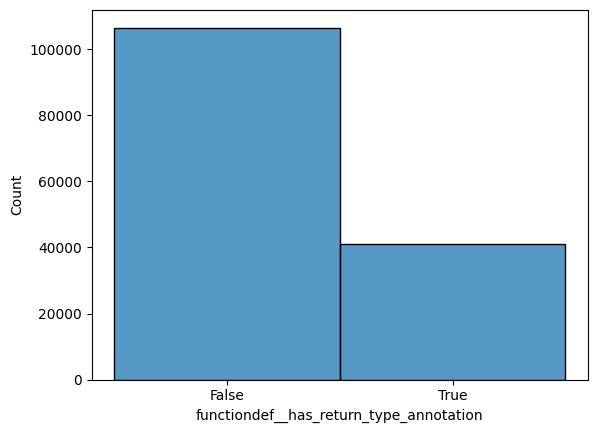

In [38]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['functiondef__has_return_type_annotation'], discrete=True)

In [39]:
#ANALISIS DE DISTRIBUCIÓN DE DATOS
num_true_values = len(X[X['functiondef__has_return_type_annotation'] == True])
num_false_values = len(X[X['functiondef__has_return_type_annotation'] == False])
std = X['functiondef__has_return_type_annotation'].std()
freq_true = len(X[X['functiondef__has_return_type_annotation'] == True]) / len(X['functiondef__has_return_type_annotation'])
freq_false = len(X[X['functiondef__has_return_type_annotation'] == False]) / len(X['functiondef__has_return_type_annotation'])
print(f'La variable has_return_type_annotation contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_return_type_annotation a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_return_type_annotation a False es {freq_false}.')

La variable has_return_type_annotation contiene 41073 valores verdaderos y 106554 valores falsos. Y, la desviación típica es de 0.44812458753585815
La frecuencia con la que programa puede tener la variable has_return_type_annotation a True es 0.27822146355341504.
La frecuencia con la que programa puede tener la variable has_return_type_annotation a False es 0.721778536446585.


In [40]:
#PROBABILIDAD DE VALORES
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'functiondef__has_return_type_annotation', possible_values)

La variable functiondef__has_return_type_annotation contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable functiondef__has_return_type_annotation toma el valor de 0.0 en un 72.18% de los items.
La variable functiondef__has_return_type_annotation toma el valor de 1.0 en un 27.82% de los items.


In [41]:
#VALORES DE LOS DATOS CONDICIONADOS A TRUE/FALSE
X[X['functiondef__has_return_type_annotation'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper,functiondef__expertise_level_BEGINNER,functiondef__expertise_level_EXPERT
count,41073.000000,41073.000000,41073.000000,41073.000000,41073.000000,41073.000000,41073.000000,41073.0,41073.0,41073.000000,41073.000000,41073.000000,41073.000000,41073.0,41073.000000,41073.000000,41073.000000,41073.0,41073.000000,41073.000000
mean,14.248119,0.119324,0.214837,3.676673,0.232633,0.054001,0.301025,1.0,0.0,1.747523,0.733670,0.006452,0.001144,0.0,0.157865,0.001096,0.833443,0.0,0.265673,0.734327
std,7.761586,0.324173,0.410714,3.644648,0.272987,0.226023,0.517989,0.0,0.0,0.496183,0.207444,0.080065,0.033809,0.0,0.364619,0.033082,0.372585,0.0,0.441696,0.441696
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.0,1.000000,0.071429,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,8.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.0,1.000000,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.000000
50%,13.000000,0.000000,0.000000,3.000000,0.166667,0.000000,0.000000,1.0,0.0,2.000000,0.750000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,1.000000
75%,19.000000,0.000000,0.000000,5.000000,0.454545,0.000000,1.000000,1.0,0.0,2.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.0,1.000000,1.000000
max,87.000000,1.000000,1.000000,83.000000,1.000000,1.000000,20.000000,1.0,0.0,6.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


### Variable has_doc_string (5/11)
Esta variable es booleana y representa si la function comienza por un String plano a modo de comentario.

<Axes: xlabel='functiondef__has_doc_string', ylabel='Count'>

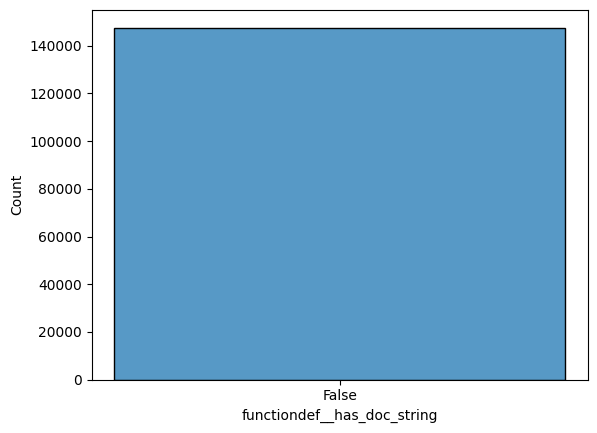

In [42]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['functiondef__has_doc_string'], discrete=True)

In [43]:
#ANALISIS DE DISTRIBUCIÓN DE DATOS
num_true_values = len(X[X['functiondef__has_doc_string'] == True])
num_false_values = len(X[X['functiondef__has_doc_string'] == False])
std = X['functiondef__has_doc_string'].std()
freq_true = len(X[X['functiondef__has_doc_string'] == True]) / len(X['functiondef__has_doc_string'])
freq_false = len(X[X['functiondef__has_doc_string'] == False]) / len(X['functiondef__has_doc_string'])
print(f'La variable has_doc_string contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_doc_string a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_doc_string a False es {freq_false}.')

La variable has_doc_string contiene 0 valores verdaderos y 147627 valores falsos. Y, la desviación típica es de 0.0
La frecuencia con la que programa puede tener la variable has_doc_string a True es 0.0.
La frecuencia con la que programa puede tener la variable has_doc_string a False es 1.0.


In [44]:
#PROBABILIDAD DE VALORES
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'functiondef__has_doc_string', possible_values)

La variable functiondef__has_doc_string contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable functiondef__has_doc_string toma el valor de 0.0 en un 100.0% de los items.
La variable functiondef__has_doc_string toma el valor de True en un 0.0% de los items. [OUTLIER]


In [45]:
#VALORES DE LOS DATOS CONDICIONADOS A TRUE/FALSE
X[X['functiondef__has_doc_string'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper,functiondef__expertise_level_BEGINNER,functiondef__expertise_level_EXPERT
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Variable number_of_characters (6/11)
Esta variable representa el número de caracteres que tiene el nombre de la funcion. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 87. Con una media de 13.70.

<Axes: ylabel='functiondef__number_of_characters'>

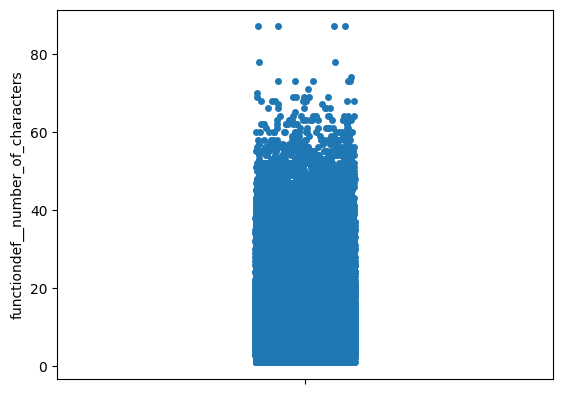

In [46]:
sns.stripplot(X['functiondef__number_of_characters'])

In [47]:
print_outliers_for_df_column(X, 'functiondef__number_of_characters')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.7204242233158082
Rango valores atípicos extremos (Tukey): [-22.0,48.0]
Rango valores atípicos leves (Tukey): [-7.0,33.0]
Rango valores atípicos extremos (Fixed BoxPlot): [6.794896543231163,285.66791642848204]
-3.0IQR: 0 instancias tienen un valor para functiondef__number_of_characters inferior a -22.0 (Q1-3*IQR) para functiondef__number_of_characters. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para functiondef__number_of_characters inferior a -7.0 (Q1-1.5*IQR) para functiondef__number_of_characters. Representando un 0.0% del total de instancias.
+1.5IQR: 4457 instancias tienen un valor para functiondef__number_of_characters superior a 33.0 (Q3+1.5*IQR) para functiondef__number_of_characters. Representando un 3.019% del total de instancias.
+3.0IQR: 536 instancias tienen un valor para functiondef__number_of_characters superior a 48.0 (Q3-3*IQR) para functiondef__number_of_characters. Re

In [48]:
X[X['functiondef__number_of_characters'] > 48].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper,functiondef__expertise_level_BEGINNER,functiondef__expertise_level_EXPERT
count,536.000000,536.0,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.0,536.000000,536.000000,536.000000,536.0,536.0,536.0,536.000000,536.000000,536.0,536.000000,536.000000
mean,55.039181,0.0,0.024254,6.736940,0.277930,0.055970,0.406716,0.151119,0.0,1.466418,0.194216,0.009328,0.0,0.0,0.0,0.031716,0.958955,0.0,0.022388,0.977612
std,6.206144,0.0,0.153980,5.720256,0.292468,0.230079,0.748002,0.358500,0.0,0.499337,0.379314,0.096222,0.0,0.0,0.0,0.175408,0.198579,0.0,0.148080,0.148080
min,49.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
25%,50.000000,0.0,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,1.000000
50%,53.000000,0.0,0.000000,5.000000,0.222222,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,1.000000
75%,58.000000,0.0,0.000000,9.000000,0.439236,0.000000,1.000000,0.000000,0.0,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,1.000000
max,87.000000,0.0,1.000000,41.000000,1.000000,1.000000,5.000000,1.000000,0.0,2.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,0.0,1.000000,1.000000


El 97% de estas funciones con nombres muy largos son de expertos y en SnakeCase.

### Variable body_count (7/11)
Esta variable representa el número de sentencias en el root de la función. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 364. Con una media de 4.09.

<Axes: ylabel='functiondef__body_count'>

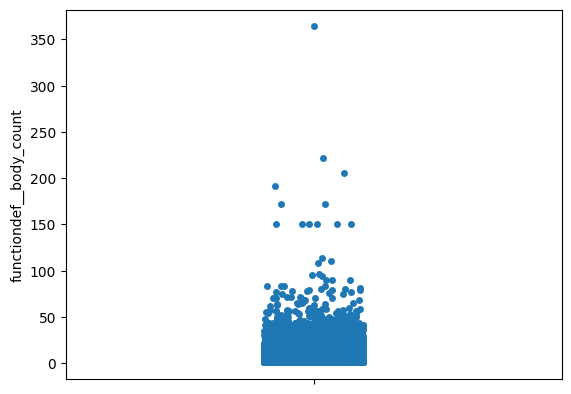

In [49]:
sns.stripplot(X['functiondef__body_count'])

In [50]:
print_outliers_for_df_column(X, 'functiondef__body_count')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.6055963721769835
Rango valores atípicos extremos (Tukey): [-11.0,17.0]
Rango valores atípicos leves (Tukey): [-5.0,11.0]
Rango valores atípicos extremos (Fixed BoxPlot): [0.27951294715975006,72.63630925007124]
-3.0IQR: 0 instancias tienen un valor para functiondef__body_count inferior a -11.0 (Q1-3*IQR) para functiondef__body_count. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para functiondef__body_count inferior a -5.0 (Q1-1.5*IQR) para functiondef__body_count. Representando un 0.0% del total de instancias.
+1.5IQR: 7543 instancias tienen un valor para functiondef__body_count superior a 11.0 (Q3+1.5*IQR) para functiondef__body_count. Representando un 5.109% del total de instancias.
+3.0IQR: 2726 instancias tienen un valor para functiondef__body_count superior a 17.0 (Q3-3*IQR) para functiondef__body_count. Representando un 1.847% del total de instancias.
L: 0 instancias tienen un valor

In [51]:
X[X['functiondef__body_count'] > 72].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper,functiondef__expertise_level_BEGINNER,functiondef__expertise_level_EXPERT
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.0,38.000000,38.000000,38.0,38.000000,38.000000,38.000000,38.0,38.0,38.000000,38.000000,38.000000,38.0,38.000000,38.000000
mean,11.394737,0.236842,0.052632,117.473686,0.367730,0.0,0.078947,0.105263,0.0,1.631579,0.105263,0.078947,0.0,0.0,0.078947,0.052632,0.789474,0.0,0.210526,0.789474
std,6.692228,0.430851,0.226294,58.408966,0.327044,0.0,0.273276,0.311012,0.0,0.488852,0.311012,0.273276,0.0,0.0,0.273276,0.226294,0.413155,0.0,0.413155,0.413155
min,3.000000,0.000000,0.000000,75.000000,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,8.000000,0.000000,0.000000,79.250000,0.057081,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.000000,1.000000
50%,8.000000,0.000000,0.000000,90.000000,0.210909,0.0,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.000000,1.000000
75%,15.500000,0.000000,0.000000,150.000000,0.666667,0.0,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.000000,1.000000
max,27.000000,1.000000,1.000000,364.000000,1.000000,0.0,1.000000,1.000000,0.0,2.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


Un 79% de expertos. Mal uso de la encapsulación?

### Variable number_of_decorators (8/11)
Esta variable representa el número de decoradores de la funcion. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 46. Con una media de 0.19.

<Axes: ylabel='functiondef__number_of_decorators'>

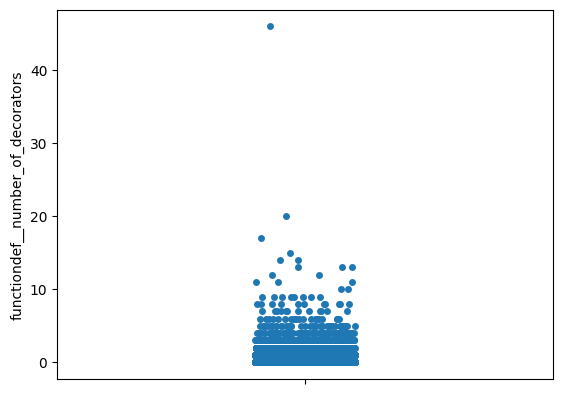

In [52]:
sns.stripplot(X['functiondef__number_of_decorators'])

In [53]:
print_outliers_for_df_column(X, 'functiondef__number_of_decorators')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.8043446416650618
Rango valores atípicos extremos (Tukey): [0.0,0.0]
Rango valores atípicos leves (Tukey): [0.0,0.0]
Rango valores atípicos extremos (Fixed BoxPlot): [0.0,0.0]
-3.0IQR: 0 instancias tienen un valor para functiondef__number_of_decorators inferior a 0.0 (Q1-3*IQR) para functiondef__number_of_decorators. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para functiondef__number_of_decorators inferior a 0.0 (Q1-1.5*IQR) para functiondef__number_of_decorators. Representando un 0.0% del total de instancias.
+1.5IQR: 25301 instancias tienen un valor para functiondef__number_of_decorators superior a 0.0 (Q3+1.5*IQR) para functiondef__number_of_decorators. Representando un 17.14% del total de instancias.
+3.0IQR: 25301 instancias tienen un valor para functiondef__number_of_decorators superior a 0.0 (Q3-3*IQR) para functiondef__number_of_decorators. Representando un 17.14% del total de i

In [54]:
X[X['functiondef__number_of_decorators'] > 0].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper,functiondef__expertise_level_BEGINNER,functiondef__expertise_level_EXPERT
count,25301.000000,25301.000000,25301.00000,25301.000000,25301.000000,25301.000000,25301.000000,25301.000000,25301.0,25301.000000,25301.000000,25301.000000,25301.000000,25301.000000,25301.000000,25301.000000,25301.000000,25301.000000,25301.000000,25301.000000
mean,14.769692,0.011264,0.08889,3.622979,0.239062,0.044544,1.115292,0.455476,0.0,1.789455,0.324396,0.025888,0.011778,0.000356,0.243073,0.003241,0.707047,0.008616,0.222244,0.777756
std,9.452083,0.105536,0.28459,4.436092,0.297191,0.206304,0.625755,0.498024,0.0,0.529502,0.360962,0.158805,0.107888,0.018857,0.428948,0.056838,0.455126,0.092425,0.415763,0.415763
min,1.000000,0.000000,0.00000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.000000,0.00000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,13.000000,0.000000,0.00000,2.000000,0.125000,0.000000,1.000000,0.000000,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,19.000000,0.000000,0.00000,4.000000,0.500000,0.000000,1.000000,1.000000,0.0,2.000000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,74.000000,1.000000,1.00000,84.000000,1.000000,1.000000,46.000000,1.000000,0.0,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Variable height (9/11)
Esta variable representa la distancia desde la función hasta el root del módulo (fichero). Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 10. Con una media de 1.77.

<Axes: ylabel='functiondef__height'>

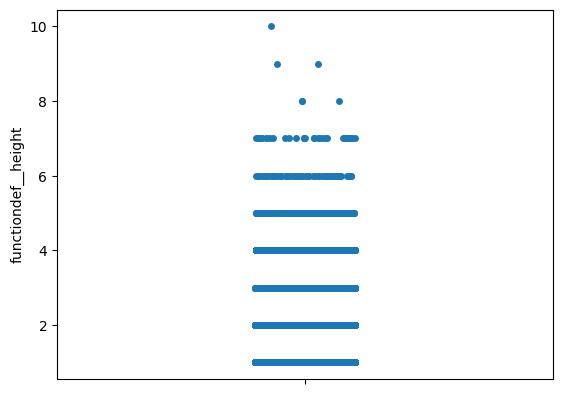

In [55]:
sns.stripplot(X['functiondef__height'])

Hay que comprobar la clase con 45 base classes. Es una clase de experto de algún tipo de interfaz gráfica.

In [56]:
print_outliers_for_df_column(X, 'functiondef__height')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.3657192643701312
Rango valores atípicos extremos (Tukey): [-2.0,5.0]
Rango valores atípicos leves (Tukey): [-0.5,3.5]
Rango valores atípicos extremos (Fixed BoxPlot): [0.5829513165800552,8.477548789585365]
-3.0IQR: 0 instancias tienen un valor para functiondef__height inferior a -2.0 (Q1-3*IQR) para functiondef__height. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para functiondef__height inferior a -0.5 (Q1-1.5*IQR) para functiondef__height. Representando un 0.0% del total de instancias.
+1.5IQR: 2243 instancias tienen un valor para functiondef__height superior a 3.5 (Q3+1.5*IQR) para functiondef__height. Representando un 1.519% del total de instancias.
+3.0IQR: 100 instancias tienen un valor para functiondef__height superior a 5.0 (Q3-3*IQR) para functiondef__height. Representando un 0.06774% del total de instancias.
L: 0 instancias tienen un valor para functiondef__height inferior a 0

In [58]:
X[X['functiondef__height'] > 8].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper,functiondef__expertise_level_BEGINNER,functiondef__expertise_level_EXPERT
count,3.000000,3.0,3.0,3.000000,3.000000,3.0,3.000000,3.0,3.0,3.000000,3.000000,3.0,3.0,3.0,3.000000,3.0,3.000000,3.0,3.0,3.0
mean,11.000000,0.0,0.0,5.000000,0.027778,0.0,0.333333,0.0,0.0,9.333333,0.238095,0.0,0.0,0.0,0.333333,0.0,0.666667,0.0,0.0,1.0
std,8.185352,0.0,0.0,6.082763,0.048113,0.0,0.577350,0.0,0.0,0.577350,0.412393,0.0,0.0,0.0,0.577350,0.0,0.577350,0.0,0.0,0.0
min,4.000000,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0,9.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0
25%,6.500000,0.0,0.0,1.500000,0.000000,0.0,0.000000,0.0,0.0,9.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.500000,0.0,0.0,1.0
50%,9.000000,0.0,0.0,2.000000,0.000000,0.0,0.000000,0.0,0.0,9.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,1.0
75%,14.500000,0.0,0.0,7.000000,0.041667,0.0,0.500000,0.0,0.0,9.500000,0.357143,0.0,0.0,0.0,0.500000,0.0,1.000000,0.0,0.0,1.0
max,20.000000,0.0,0.0,12.000000,0.083333,0.0,1.000000,0.0,0.0,10.000000,0.714286,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0,0.0,1.0


In [59]:
X[X['functiondef__height'] == 2].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper,functiondef__expertise_level_BEGINNER,functiondef__expertise_level_EXPERT
count,91557.000000,91557.000000,91557.000000,91557.000000,91557.000000,91557.000000,91557.000000,91557.000000,91557.0,91557.0,91557.000000,91557.000000,91557.000000,91557.000000,91557.000000,91557.000000,91557.000000,91557.000000,91557.000000,91557.000000
mean,12.480684,0.198379,0.142807,3.797066,0.217972,0.027251,0.207619,0.315323,0.0,2.0,0.232801,0.057811,0.004882,0.000098,0.200258,0.006914,0.727263,0.002774,0.375875,0.624125
std,7.596506,0.398781,0.349878,4.700446,0.281921,0.162814,0.439517,0.464647,0.0,0.0,0.322974,0.233387,0.069702,0.009914,0.400195,0.082861,0.445369,0.052598,0.484351,0.484351
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,0.000000,0.000000,2.000000,0.083333,0.000000,0.000000,0.000000,0.0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,16.000000,0.000000,0.000000,5.000000,0.384615,0.000000,0.000000,1.000000,0.0,2.0,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,74.000000,1.000000,1.000000,364.000000,1.000000,1.000000,7.000000,1.000000,0.0,2.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Hay muchisimas funciones con height == 2. Se debe a que un gran porcentaje de funciones son métodos de clases con height 1.

### Variable expressions_pct (10/11)
Esta variable representa la proporción de las sentencias en el root de la funcsion que son expresiones. Toma los valores de 0.0 - 1.0. La media es 0.22.

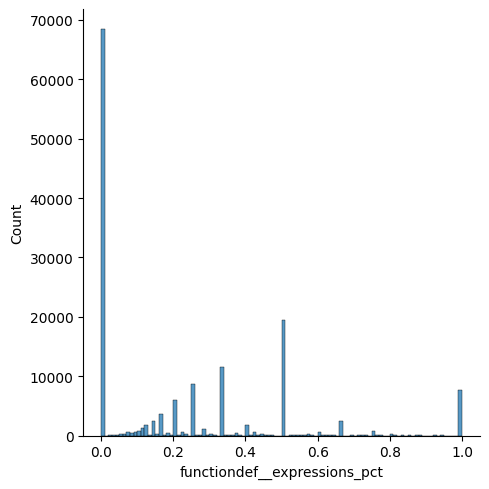

In [60]:
sns.displot(X['functiondef__expressions_pct'], bins=[i / 100 for i in range(0, 101)])

In [61]:
print_outliers_for_df_column(X, 'functiondef__expressions_pct')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.5025212913751602
Rango valores atípicos extremos (Tukey): [-1.0000000298023224,1.3333333730697632]
Rango valores atípicos leves (Tukey): [-0.5000000149011612,0.833333358168602]
Rango valores atípicos extremos (Fixed BoxPlot): [-0.08612361159675211,4.065309950261315]
-3.0IQR: 0 instancias tienen un valor para functiondef__expressions_pct inferior a -1.0000000298023224 (Q1-3*IQR) para functiondef__expressions_pct. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para functiondef__expressions_pct inferior a -0.5000000149011612 (Q1-1.5*IQR) para functiondef__expressions_pct. Representando un 0.0% del total de instancias.
+1.5IQR: 8051 instancias tienen un valor para functiondef__expressions_pct superior a 0.833333358168602 (Q3+1.5*IQR) para functiondef__expressions_pct. Representando un 5.454% del total de instancias.
+3.0IQR: 0 instancias tienen un valor para functiondef__expressions_pct superi

In [62]:
X[X['functiondef__expressions_pct'] == 1].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper,functiondef__expertise_level_BEGINNER,functiondef__expertise_level_EXPERT
count,7744.000000,7744.000000,7744.000000,7744.000000,7744.0,7744.000000,7744.000000,7744.000000,7744.0,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000
mean,12.399148,0.131069,0.076575,1.696668,1.0,0.031508,0.276343,0.290418,0.0,1.955837,0.238737,0.125517,0.007361,0.000258,0.231405,0.013817,0.621513,0.000129,0.349819,0.650181
std,7.705590,0.337498,0.265934,2.004917,0.0,0.174698,0.595370,0.453985,0.0,0.661958,0.347079,0.331325,0.085483,0.016070,0.421758,0.116739,0.485041,0.011364,0.476944,0.476943
min,1.000000,0.000000,0.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.000000,0.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11.000000,0.000000,0.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,16.000000,0.000000,0.000000,2.000000,1.0,0.000000,0.000000,1.000000,0.0,2.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,68.000000,1.000000,1.000000,79.000000,1.0,1.000000,12.000000,1.000000,0.0,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Variable type_annotations_pct (11/11)
Esta variable representa la proporción de los parámetros que tienen anotación de tipo en la función (incluyendo el return). Este campo toma valores del 0.0 - 1.0. Su media es 0.23.

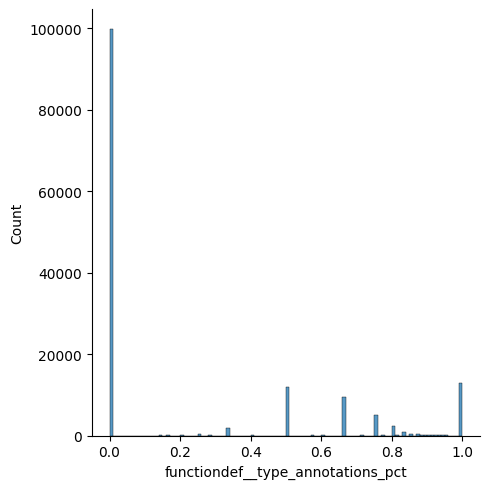

In [63]:
sns.displot(X['functiondef__type_annotations_pct'], bins=[i / 100 for i in range(0, 101)])

In [64]:
print_outliers_for_df_column(X, 'functiondef__type_annotations_pct')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.4091097414493561
Rango valores atípicos extremos (Tukey): [-1.5,2.0]
Rango valores atípicos leves (Tukey): [-0.75,1.25]
Rango valores atípicos extremos (Fixed BoxPlot): [-0.1791438494752272,4.352633318583586]
-3.0IQR: 0 instancias tienen un valor para functiondef__type_annotations_pct inferior a -1.5 (Q1-3*IQR) para functiondef__type_annotations_pct. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para functiondef__type_annotations_pct inferior a -0.75 (Q1-1.5*IQR) para functiondef__type_annotations_pct. Representando un 0.0% del total de instancias.
+1.5IQR: 0 instancias tienen un valor para functiondef__type_annotations_pct superior a 1.25 (Q3+1.5*IQR) para functiondef__type_annotations_pct. Representando un 0.0% del total de instancias.
+3.0IQR: 0 instancias tienen un valor para functiondef__type_annotations_pct superior a 2.0 (Q3-3*IQR) para functiondef__type_annotations_pct. Representa

In [65]:
X[X['functiondef__type_annotations_pct'] == 1].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper,functiondef__expertise_level_BEGINNER,functiondef__expertise_level_EXPERT
count,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.0,12832.000000,12832.0,12832.000000,12832.0,12832.0,12832.000000,12832.000000,12832.000000,12832.0,12832.000000,12832.000000
mean,18.780237,0.003663,0.245480,4.561721,0.225081,0.030393,0.248052,0.913342,0.0,1.194903,1.0,0.002494,0.0,0.0,0.075358,0.000935,0.921213,0.0,0.300187,0.699813
std,9.104243,0.060412,0.430388,4.334065,0.252878,0.171672,0.696666,0.281345,0.0,0.532737,0.0,0.049877,0.0,0.0,0.263979,0.030567,0.269417,0.0,0.458357,0.458357
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,13.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,1.0,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.000000
50%,18.000000,0.000000,0.000000,3.000000,0.166667,0.000000,0.000000,1.000000,0.0,1.000000,1.0,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.000000,1.000000
75%,23.000000,0.000000,0.000000,6.000000,0.333333,0.000000,0.000000,1.000000,0.0,1.000000,1.0,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0,1.000000,1.000000
max,87.000000,1.000000,1.000000,83.000000,1.000000,1.000000,20.000000,1.000000,0.0,6.000000,1.0,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000
